In [1]:
#Importing libraries
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [88]:
missing_values = ["n/a", "na", "--", ""]

df_train = pd.read_csv('clean_train_data.csv', na_values = missing_values)
#df_train['type'] = 'analysis'
#df_test = pd.read_csv('test.csv', na_values = missing_values)
#df_test['SalePrice'] = ""
#df_test['type'] = 'scoring'

#df = pd.concat([df_train, df_test])

### Handling Missing Values

In [89]:
#Check which columns have missing values
df_train.isnull().sum()

Unnamed: 0         0
Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 82, dtype: int64

In [4]:
# remove columns with too many missing values
df_train.drop(['Alley', 'PoolQC', 'Fence', 'MiscFeature'], axis=1, inplace=True)

In [5]:
# missing values for these columns maybe means no basement
df_train['BsmtQual'] = df_train['BsmtQual'].fillna('no_bsmt')
df_train['BsmtCond'] = df_train['BsmtCond'].fillna('no_bsmt')
df_train['BsmtExposure'] = df_train['BsmtExposure'].fillna('no_bsmt')
df_train['BsmtFinType1'] = df_train['BsmtFinType1'].fillna('no_bsmt')
df_train['BsmtFinType2'] = df_train['BsmtFinType2'].fillna('no_bsmt')

In [6]:
# missing values for these columns maybe means no garage
df_train['GarageType'] = df_train['GarageType'].fillna('no_garage')
df_train['GarageFinish'] = df_train['GarageFinish'].fillna('no_garage')
df_train['GarageQual'] = df_train['GarageQual'].fillna('no_garage')
df_train['GarageCond'] = df_train['GarageCond'].fillna('no_garage')

In [7]:
# missing values for these columns maybe means no fireplace
df_train['FireplaceQu'] = df_train['FireplaceQu'].fillna('no_fireplace')

In [8]:
# houses without a garage would not have a garage year built... impute random number to indicate this (9999)
df_train['GarageYrBlt'] = df_train['GarageYrBlt'].fillna(9999)

In [90]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

df_cont = df_train.select_dtypes(include=numerics)
df_cat = df_train.select_dtypes(include = 'object')

In [91]:
#imputing median values for missing numerical values
df_cont = df_cont.fillna(df_cont.median())

In [92]:
df_cont.drop(['Id'], axis=1, inplace=True)

In [93]:
df = pd.concat([df_cont, df_cat], axis = 1)

In [13]:
#remove remaining rows with missing value
df = df.dropna()
df = df.reset_index(drop=True)

In [94]:
#check that there are no more missing values
df.isnull().sum()

Unnamed: 0          0
MSSubClass          0
LotFrontage         0
LotArea             0
OverallQual         0
                 ... 
PoolQC           1453
Fence            1179
MiscFeature      1406
SaleType            0
SaleCondition       0
Length: 81, dtype: int64

### Feature Analysis

In [82]:
#split data into categorical and continuous variables for analysis
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

df_cont = df.select_dtypes(include=numerics)
df_cat = df.select_dtypes(include = 'object')

In [16]:
# impute outliers with Lower Bound and Upper Bound values
def outliers (dataframe):
    
    for column in dataframe:
        Q1 = dataframe[column].quantile(0.25)
        Q3 = dataframe[column].quantile(0.75)
        IQR = Q3 - Q1
        Lower_Bound = Q1 - 1.5*IQR
        Upper_Bound = Q3 + 1.5*IQR
        
        for i in np.linspace(0,len(dataframe[column])-1, len(dataframe[column])):
            if dataframe[column][i] < Lower_Bound:
                dataframe[column][i] = Q1
            elif dataframe[column][i] > Upper_Bound:
                dataframe[column][i] = Q3
                
    return dataframe

In [17]:
df_cont2 =  df_cont.loc[:, df_cont.columns != 'SalePrice']

In [18]:
df_cont2 = outliers(df_cont2)

In [19]:
#creating dummy variables for the categorical variables
df_cat_dc = pd.get_dummies(df_cat)

### Lasso on continuous variables and combinging dummy variables after

In [20]:
#combining categorical and continuous variables together with the response variable
df = pd.concat([df_cont2, df_cont['SalePrice']], axis = 1)
df

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
0             60         65.0   8450.0            7            5       2003   
1             20         80.0   9600.0            6            6       1976   
2             60         68.0  11250.0            7            5       2001   
3             70         60.0   9550.0            7            5       1915   
4             60         84.0  14260.0            8            5       2000   
...          ...          ...      ...          ...          ...        ...   
1446          60         62.0   7917.0            6            5       1999   
1447          20         85.0  13175.0            6            6       1978   
1448          70         66.0   9042.0            7            6       1941   
1449          20         68.0   9717.0            5            6       1950   
1450          20         75.0   9937.0            5            6       1965   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  WoodDeckSF  \
0             2003       196.0         706           0  ...           0   
1             1976         0.0         978           0  ...         298   
2             2002       162.0         486           0  ...           0   
3             1970         0.0         216           0  ...           0   
4             2000       350.0         655           0  ...         192   
...            ...         ...         ...         ...  ...         ...   
1446          2000         0.0           0           0  ...           0   
1447          1988       119.0         790           0  ...         349   
1448          2006         0.0         275           0  ...           0   
1449          1996         0.0          49           0  ...         366   
1450          1965         0.0         830           0  ...         168   

      OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  MiscVal  \
0              61              0          0            0         0        0   
1               0              0          0            0         0        0   
2              42              0          0            0         0        0   
3              35              0          0            0         0        0   
4              84              0          0            0         0        0   
...           ...            ...        ...          ...       ...      ...   
1446           40              0          0            0         0        0   
1447            0              0          0            0         0        0   
1448           60              0          0            0         0        0   
1449            0              0          0            0         0        0   
1450           68              0          0            0         0        0   

      MoSold  YrSold  SalePrice  
0          2    2008     208500  
1          5    2007     181500  
2          9    2008     223500  
3          2    2006     140000  
4         12    2008     250000  
...      ...     ...        ...  
1446       8    2007     175000  
1447       2    2010     210000  
1448       5    2010     266500  
1449       4    2010     142125  
1450       6    2008     147500  

[1451 rows x 37 columns]

In [21]:
#Using lasso to eliminate some features
X_lasso = df.loc[:, df.columns != 'SalePrice']
y = df['SalePrice']

from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV

cv = KFold(n_splits=10, shuffle=True, random_state=10)
model = LassoCV(cv=cv)
lassocv = model.fit(X_lasso, y)

B_lasso = lassocv.coef_
B_lasso = np.insert(B_lasso, 0, lassocv.intercept_, axis=0)

print('The Coef are')
print(B_lasso)
#print('\nlambda best is = %f' % lassocv.alpha_)

The Coef are
[-1.28857938e+06 -0.00000000e+00  0.00000000e+00  2.20284694e+00
  0.00000000e+00  0.00000000e+00  2.90207014e+02  3.45965832e+02
  7.66963380e+00  3.58341392e+01  0.00000000e+00  1.06757936e+01
  3.81309830e+01  5.34386001e+01  6.18860289e+01  0.00000000e+00
  7.49602959e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  5.95420790e+01
  3.78504342e+01  7.74986606e+01  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -0.00000000e+00
 -0.00000000e+00]


In [22]:
df =  df.loc[:, df.columns != 'SalePrice'] * lassocv.coef_
df.columns[0:9]

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1'],
      dtype='object')

In [23]:
df = df.loc[:, (df != 0).any(axis=0)]
df

LotArea      YearBuilt   YearRemodAdd   MasVnrArea    BsmtFinSF1  \
0     18614.056668  581284.649418  692969.561590  1503.248225  25298.902305   
1     21147.330652  573449.060035  683628.484124     0.000000  35045.788179   
2     24782.028108  580704.235390  692623.595758  1242.480676  17415.391672   
3     21037.188305  555746.432170  681552.689132     0.000000   7740.174076   
4     31412.597406  580414.028376  691931.664094  2684.371830  23471.361204   
...            ...            ...            ...          ...           ...   
1446  17439.939247  580123.821361  691931.664094     0.000000      0.000000   
1447  29022.508473  574029.474064  687780.074109   912.686422  28308.970001   
1448  19918.142058  563291.814539  694007.459086     0.000000   9854.388292   
1449  21405.063744  565903.677666  690547.800765     0.000000   1755.872823   
1450  21889.690072  570256.782879  679822.859972     0.000000  29742.335571   

         BsmtUnfSF   TotalBsmtSF       1stFlrSF      2ndFlrSF     GrLivArea  \
0      1601.369044  32640.121436   45743.441727  52850.668697  12818.210603   
1      3031.925390  48121.300529   67439.513387      0.000000   9459.989346   
2      4633.294434  35080.504348   49163.512136  53593.301044  13387.908852   
3      5764.928559  28827.023138   51354.494742  46785.837863  12870.682810   
4      5231.138877  43659.975520   61187.197169  65165.988452  16476.273044   
...            ...           ...            ...           ...           ...   
1446  10174.031327  36338.826786   50926.985941  42948.904070  12345.960739   
1447   6288.042447  58797.975765  110778.218106      0.000000  15539.269345   
1448   9362.671011  43926.892400   63485.056976  71292.705315  17540.709246   
1449      0.000000  41105.199659   57606.810959      0.000000   8080.719901   
1450   1451.907933  47892.514631   67118.881786      0.000000   9415.013168   

        GarageArea    WoodDeckSF  OpenPorchSF  
0     32629.059278      0.000000  4727.418296  
1     27389.356328  11279.429402     0.000000  
2     36201.584016      0.000000  3254.943745  
3     38226.014701      0.000000  2712.453121  
4     49777.178022   7267.283373  6509.887490  
...            ...           ...          ...  
1446  27389.356328      0.000000  3099.946424  
1447  29771.039487  13209.801548     0.000000  
1448  15004.603901      0.000000  4649.919636  
1449  14290.098954  13853.258930     0.000000  
1450  16433.613797   6358.872952  5269.908920  

[1451 rows x 13 columns]

In [24]:
#combining categorical and continuous variables together with the response variable
df1 = pd.concat([df, df_cat_dc], axis = 1)
df1 = pd.concat([df1, df_cont['SalePrice']], axis = 1)
df1

LotArea      YearBuilt   YearRemodAdd   MasVnrArea    BsmtFinSF1  \
0     18614.056668  581284.649418  692969.561590  1503.248225  25298.902305   
1     21147.330652  573449.060035  683628.484124     0.000000  35045.788179   
2     24782.028108  580704.235390  692623.595758  1242.480676  17415.391672   
3     21037.188305  555746.432170  681552.689132     0.000000   7740.174076   
4     31412.597406  580414.028376  691931.664094  2684.371830  23471.361204   
...            ...            ...            ...          ...           ...   
1446  17439.939247  580123.821361  691931.664094     0.000000      0.000000   
1447  29022.508473  574029.474064  687780.074109   912.686422  28308.970001   
1448  19918.142058  563291.814539  694007.459086     0.000000   9854.388292   
1449  21405.063744  565903.677666  690547.800765     0.000000   1755.872823   
1450  21889.690072  570256.782879  679822.859972     0.000000  29742.335571   

         BsmtUnfSF   TotalBsmtSF       1stFlrSF      2ndFlrSF     GrLivArea  \
0      1601.369044  32640.121436   45743.441727  52850.668697  12818.210603   
1      3031.925390  48121.300529   67439.513387      0.000000   9459.989346   
2      4633.294434  35080.504348   49163.512136  53593.301044  13387.908852   
3      5764.928559  28827.023138   51354.494742  46785.837863  12870.682810   
4      5231.138877  43659.975520   61187.197169  65165.988452  16476.273044   
...            ...           ...            ...           ...           ...   
1446  10174.031327  36338.826786   50926.985941  42948.904070  12345.960739   
1447   6288.042447  58797.975765  110778.218106      0.000000  15539.269345   
1448   9362.671011  43926.892400   63485.056976  71292.705315  17540.709246   
1449      0.000000  41105.199659   57606.810959      0.000000   8080.719901   
1450   1451.907933  47892.514631   67118.881786      0.000000   9415.013168   

      ...  SaleType_New  SaleType_Oth  SaleType_WD  SaleCondition_Abnorml  \
0     ...             0             0            1                      0   
1     ...             0             0            1                      0   
2     ...             0             0            1                      0   
3     ...             0             0            1                      1   
4     ...             0             0            1                      0   
...   ...           ...           ...          ...                    ...   
1446  ...             0             0            1                      0   
1447  ...             0             0            1                      0   
1448  ...             0             0            1                      0   
1449  ...             0             0            1                      0   
1450  ...             0             0            1                      0   

      SaleCondition_AdjLand  SaleCondition_Alloca  SaleCondition_Family  \
0                         0                     0                     0   
1                         0                     0                     0   
2                         0                     0                     0   
3                         0                     0                     0   
4                         0                     0                     0   
...                     ...                   ...                   ...   
1446                      0                     0                     0   
1447                      0                     0                     0   
1448                      0                     0                     0   
1449                      0                     0                     0   
1450                      0                     0                     0   

      SaleCondition_Normal  SaleCondition_Partial  SalePrice  
0                        1                      0     208500  
1                        1                      0     181500  
2                        1                      0     223500  
3                        0         

In [25]:
df2 = pd.concat([df, df_cat], axis = 1)
df2 = pd.concat([df2, df_cont['SalePrice']], axis = 1)
df2

LotArea      YearBuilt   YearRemodAdd   MasVnrArea    BsmtFinSF1  \
0     18614.056668  581284.649418  692969.561590  1503.248225  25298.902305   
1     21147.330652  573449.060035  683628.484124     0.000000  35045.788179   
2     24782.028108  580704.235390  692623.595758  1242.480676  17415.391672   
3     21037.188305  555746.432170  681552.689132     0.000000   7740.174076   
4     31412.597406  580414.028376  691931.664094  2684.371830  23471.361204   
...            ...            ...            ...          ...           ...   
1446  17439.939247  580123.821361  691931.664094     0.000000      0.000000   
1447  29022.508473  574029.474064  687780.074109   912.686422  28308.970001   
1448  19918.142058  563291.814539  694007.459086     0.000000   9854.388292   
1449  21405.063744  565903.677666  690547.800765     0.000000   1755.872823   
1450  21889.690072  570256.782879  679822.859972     0.000000  29742.335571   

         BsmtUnfSF   TotalBsmtSF       1stFlrSF      2ndFlrSF     GrLivArea  \
0      1601.369044  32640.121436   45743.441727  52850.668697  12818.210603   
1      3031.925390  48121.300529   67439.513387      0.000000   9459.989346   
2      4633.294434  35080.504348   49163.512136  53593.301044  13387.908852   
3      5764.928559  28827.023138   51354.494742  46785.837863  12870.682810   
4      5231.138877  43659.975520   61187.197169  65165.988452  16476.273044   
...            ...           ...            ...           ...           ...   
1446  10174.031327  36338.826786   50926.985941  42948.904070  12345.960739   
1447   6288.042447  58797.975765  110778.218106      0.000000  15539.269345   
1448   9362.671011  43926.892400   63485.056976  71292.705315  17540.709246   
1449      0.000000  41105.199659   57606.810959      0.000000   8080.719901   
1450   1451.907933  47892.514631   67118.881786      0.000000   9415.013168   

      ...  Functional   FireplaceQu  GarageType GarageFinish GarageQual  \
0     ...         Typ  no_fireplace      Attchd          RFn         TA   
1     ...         Typ            TA      Attchd          RFn         TA   
2     ...         Typ            TA      Attchd          RFn         TA   
3     ...         Typ            Gd      Detchd          Unf         TA   
4     ...         Typ            TA      Attchd          RFn         TA   
...   ...         ...           ...         ...          ...        ...   
1446  ...         Typ            TA      Attchd          RFn         TA   
1447  ...        Min1            TA      Attchd          Unf         TA   
1448  ...         Typ            Gd      Attchd          RFn         TA   
1449  ...         Typ  no_fireplace      Attchd          Unf         TA   
1450  ...         Typ  no_fireplace      Attchd          Fin         TA   

     GarageCond PavedDrive SaleType SaleCondition SalePrice  
0            TA          Y       WD        Normal    208500  
1            TA          Y       WD        Normal    181500  
2            TA          Y       WD        Normal    223500  
3            TA          Y       WD       Abnorml    140000  
4            TA          Y       WD        Normal    250000  
...         ...        ...      ...           ...       ...  
1446         TA          Y       WD        Normal    175000  
1447         TA          Y       WD        Normal    210000  
1448         TA          Y       WD        Normal    266500  
1449         TA          Y       WD        Normal    142125  
1450         TA          Y       WD        Normal    147500  

[1451 rows x 53 columns]

### Run Regressions

In [26]:
# 10-Fold Cross Validation

def cross_validation (df, func):
    from sklearn.model_selection import KFold
    kf = KFold(n_splits = 10, shuffle = True, random_state = 10)
    kf_rmse = []
    
    for train, test in kf.split(df):
        X_train = df.iloc[train].loc[:, df.columns != 'SalePrice']
        X_train = X_train.squeeze()
        X_test = df.iloc[test].loc[:, df.columns != 'SalePrice']
        y_train = df.iloc[train].loc[:,'SalePrice']
        y_test = df.iloc[test].loc[:,'SalePrice']
        
        reg = func.fit(X_train, y_train)
        y_hat = reg.predict(X_test)
        
        from sklearn.metrics import mean_squared_error
        kf_rmse.append(mean_squared_error(y_test, y_hat, squared=False))
        
    kf_RMSE = (1/10) * np.sum(kf_rmse)
        
    return (kf_RMSE)

In [27]:
#Check which one produces higher R2 score and lower cv-rmse
from sklearn.linear_model import LinearRegression
model = LinearRegression()
x = df1.loc[:, df1.columns != 'SalePrice']
y = df1['SalePrice']

model.fit(x, y)

y_hat = model.predict(x)

score = model.score(x, y)
print(score)
cross_validation(df1,LinearRegression())

0.8974527608665189


32640.33328979212

In [28]:
from sklearn.neighbors import KNeighborsRegressor

x = df1.loc[:, df1.columns != 'SalePrice']
y = df1['SalePrice']

mse2 = []

for i in range(1,50,1):
    reg = KNeighborsRegressor(n_neighbors = i).fit(x,y)
    y_hat = reg.predict(x)
    mse2.append(cross_validation(df1,KNeighborsRegressor(n_neighbors = i)))
#mse2
#n_neighbors = 6 produced the smallest mse

In [29]:
from sklearn.neighbors import KNeighborsRegressor

x = df1.loc[:, df1.columns != 'SalePrice']
y = df1['SalePrice']

model2 = KNeighborsRegressor(n_neighbors = 6)
model2.fit(x,y)

y_hat = model2.predict(x)

score = model2.score(x, y)
print(score)

cross_validation(df1,KNeighborsRegressor(n_neighbors = 6))

0.8184493396438476


39799.42085171912

In [30]:
from sklearn.tree import DecisionTreeRegressor

x = df1.loc[:, df1.columns != 'SalePrice']
y = df1['SalePrice']

mse2 = []

for i in range(1,20,1):
    reg = DecisionTreeRegressor(max_depth=i).fit(x,y)
    y_hat = reg.predict(x)
    mse2.append(cross_validation(df1,DecisionTreeRegressor(max_depth=i)))
#mse2
#max_depth = 8 produced the smallest mse

In [31]:
from sklearn.tree import DecisionTreeRegressor

x = df1.loc[:, df1.columns != 'SalePrice']
y = df1['SalePrice']

model3 = DecisionTreeRegressor(max_depth=8)
model3.fit(x,y)

y_hat = model3.predict(x)

score = model3.score(x, y)
print(score)

cross_validation(df1,DecisionTreeRegressor(max_depth=8))

0.9487391735672727


43647.56234709412

<BarContainer object of 9 artists>

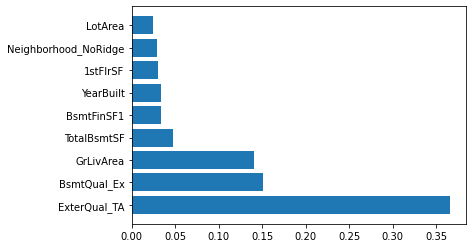

In [32]:
df_feature = pd.DataFrame(zip(x.columns, model3.feature_importances_), columns = ['importance','feature'])
df_feature = df_feature.sort_values(by=['feature'], ascending=False)
plt.barh(df_feature['importance'][0:9], df_feature['feature'][0:9])

In [33]:
# random forest
from sklearn.ensemble import RandomForestRegressor

x = df1.loc[:, df1.columns != 'SalePrice']
y = df1['SalePrice']

model4 = RandomForestRegressor()
model4.fit(x,y)

y_hat = model4.predict(x)

score = model4.score(x, y)
print(score)

cross_validation(df1,RandomForestRegressor())

0.9781022183635835


32658.270976350203

<BarContainer object of 9 artists>

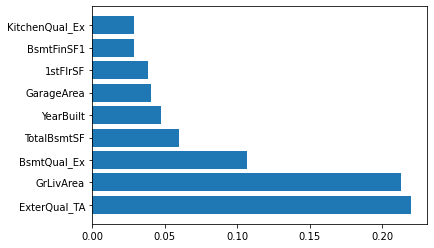

In [34]:
df_feature = pd.DataFrame(zip(x.columns, model4.feature_importances_), columns = ['importance','feature'])
df_feature = df_feature.sort_values(by=['feature'], ascending=False)
plt.barh(df_feature['importance'][0:9], df_feature['feature'][0:9])

In [45]:
# bagging
from sklearn.ensemble import BaggingRegressor

x = df1.loc[:, df1.columns != 'SalePrice']
y = df1['SalePrice']

model5 = BaggingRegressor()
model5.fit(x,y)

y_hat = model5.predict(x)

score = model5.score(x, y)
print(score)

cross_validation(df1,BaggingRegressor())

0.9575272129174778


34252.39574777316

In [78]:
from sklearn.ensemble import GradientBoostingRegressor

x = df1.loc[:, df1.columns != 'SalePrice']
y = df1['SalePrice']

cols = ['i', 'j', 'mse']
lst = []

#mse3 = pd.DataFrame(columns = ['i', 'j', 'mse'])

for i in range(3,7,1):
    for j in range(3,7,1):
        gbr_params = {'n_estimators': 1000,
          'max_depth': i,
          'min_samples_split': j,
          'learning_rate': 0.01,
          'loss': 'ls'}
        
        reg = GradientBoostingRegressor(**gbr_params).fit(x,y)
        y_hat = reg.predict(x)
        
        from sklearn.metrics import mean_squared_error
        mse = mean_squared_error(y, y_hat, squared=False)
        #mse = cross_validation(df1, GradientBoostingRegressor(**gbr_params))
        lst.append([i,j,mse])
        mse3  = pd.DataFrame(lst, columns = cols)
        
mse3

i  j           mse
0   3  3  17386.860427
1   3  4  17372.665011
2   3  5  17396.846748
3   3  6  17472.986034
4   4  3  12807.542570
5   4  4  12854.899700
6   4  5  12917.683889
7   4  6  13007.177773
8   5  3   9230.231167
9   5  4   9281.909062
10  5  5   9489.429596
11  5  6   9494.545691
12  6  3   6361.252977
13  6  4   6408.769888
14  6  5   6596.104747
15  6  6   6697.400130

In [79]:
# boosting
from sklearn.ensemble import GradientBoostingRegressor

x = df1.loc[:, df1.columns != 'SalePrice']
y = df1['SalePrice']

# Hyperparameters for GradientBoostingRegressor
#
gbr_params = {'n_estimators': 1000,
          'max_depth': 6,
          'min_samples_split': 3,
          'learning_rate': 0.01,
          'loss': 'ls'}
#
# Create an instance of gradient boosting regressor
#
model6 = GradientBoostingRegressor(**gbr_params)
#
# Fit the model
#
model6.fit(x, y)

y_hat = model6.predict(x)

score = model6.score(x, y)
print(score)

cross_validation(df1,GradientBoostingRegressor(**gbr_params))

0.9935626735077582


32046.63045066587

<BarContainer object of 9 artists>

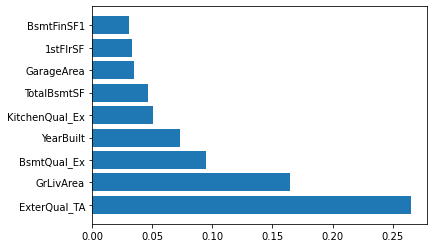

In [80]:
df_feature = pd.DataFrame(zip(x.columns, model6.feature_importances_), columns = ['importance','feature'])
df_feature = df_feature.sort_values(by=['feature'], ascending=False)
plt.barh(df_feature['importance'][0:9], df_feature['feature'][0:9])